In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import math
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Load raw data, denoised data, and ground truth

In [2]:
# path to raw data, denoised data, and ground truth
path ='/srv/home/chenyu/TensorDenoise/Simulatons/STO_simulation/'
raw_data = sio.loadmat(path + 'Simulation_noisy_STO_slice_5_1000FPS_fullsize.mat')
raw_data = raw_data['datacube']
truth_data = np.load(path + 'Simulation_truth_STO_slice_5_1000FPS_fullsize.npy')
denoised_data = sio.loadmat(path + 'Simulation_tensor_STO_slice_5_1000FPS_fullsize.mat')
denoised_data = denoised_data['est_HOOI']

In [3]:
print(denoised_data.shape)
print(raw_data.shape)
print(truth_data.shape)

(114, 114, 16384)
(114, 114, 16384)
(114, 114, 16384)


## Check denoise result using ADF image and single CBED

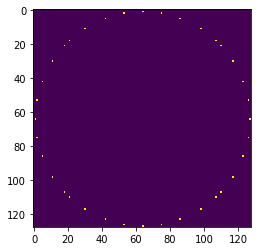

In [7]:
# A circular mask with less points can be generated by using a smaller gap between two radii
# Has to construct ADF image from very few k-space points to see the different after denoising
# If integrate over a large annular area in k-space, then the ADF from raw data will be noiseless as well
circular_mask = create_circular_mask(128, 128, center=(64,64), radius=63) & \
~create_circular_mask(128, 128, center=(64,64), radius=62.95)
plt.imshow(circular_mask)
ADF_noisy = np.zeros((raw_data.shape[0],raw_data.shape[1]))
ADF_denoised = np.zeros((raw_data.shape[0],raw_data.shape[1]))
ADF_truth = np.zeros((raw_data.shape[0],raw_data.shape[1]))

for i in range(128):
    for j in range(128):
        if circular_mask[i,j] == 1:
            ADF_noisy = ADF_noisy + raw_data[:,:,i*128+j]
            ADF_denoised = ADF_denoised + denoised_data[:,:,i*128+j]
            ADF_truth = ADF_truth + truth_data[:,:,i*128+j]

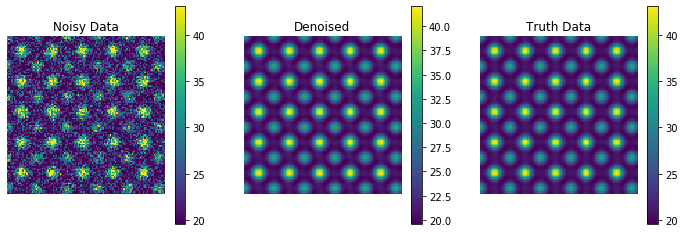

In [8]:
# Compare real space structure from ADF reconstrcutred from a ring with width = 1
plt.figure(figsize=(12,4))
clim_low = np.amin(ADF_truth)
clim_high = np.amax(ADF_truth)

plt.subplot(132)
plt.imshow(ADF_denoised)
plt.colorbar()
plt.axis('off')
plt.title('Denoised')

plt.subplot(131)
plt.imshow(ADF_noisy,clim=[clim_low,clim_high])
plt.title('Noisy Data')
plt.axis('off')
plt.colorbar()

plt.subplot(133)
plt.imshow(ADF_truth,clim=[clim_low,clim_high])
plt.title('Truth Data')
plt.axis('off')
plt.colorbar()

Text(0.5, 1.0, 'Noisy')

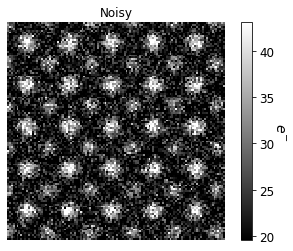

In [9]:
plt.imshow(ADF_noisy,clim=[clim_low,clim_high],cmap='gray')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=12)
cbar.set_label('$e^{-}$',rotation=270,fontsize=14, labelpad = 12)
plt.axis('off')
plt.title('Noisy')

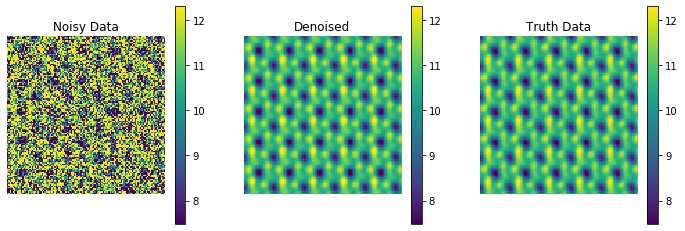

In [10]:
# Compare real space structure from single kx,ky
plt.figure(figsize=(12,4))
iframe = 10000
clim_low = np.amin(truth_data[:,:,iframe])
clim_high = np.amax(truth_data[:,:,iframe])

plt.subplot(131)
plt.imshow(raw_data[:,:,iframe],clim=[clim_low,clim_high])
plt.title('Noisy Data')
plt.axis('off')
plt.colorbar()

plt.subplot(132)
plt.imshow(denoised_data[:,:,iframe],clim=[clim_low,clim_high])
plt.colorbar()
plt.axis('off')
plt.title('Denoised')

plt.subplot(133)
plt.imshow(truth_data[:,:,iframe],clim=[clim_low,clim_high])
plt.title('Truth Data')
plt.axis('off')
plt.colorbar()

In [11]:
plt.imshow(truth_data[rx,ry,:].reshape(128,128),clim=[clim_low,clim_high],cmap='hot')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=12)
cbar.set_label('$e^{-}$',rotation=270,fontsize=14, labelpad = 12)
plt.axis('off')
# plt.title('Noisy')

NameError: name 'rx' is not defined

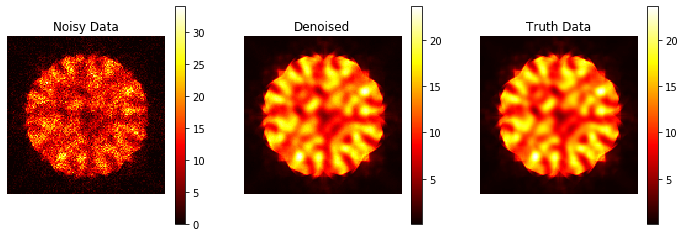

In [12]:
# Compare CBED from single rx,ry
plt.figure(figsize=(12,4))
rx = 50
ry = 50
clim_low = np.amin(truth_data[rx,ry,:])
clim_high = np.amax(truth_data[rx,ry,:])

plt.subplot(132)
plt.imshow(denoised_data[rx,ry,:].reshape(128,128),clim=[clim_low,clim_high],cmap='hot')
plt.colorbar()
plt.axis('off')
plt.title('Denoised')

plt.subplot(131)
plt.imshow(raw_data[rx,ry,:].reshape(128,128),cmap='hot')
plt.title('Noisy Data')
plt.axis('off')
plt.colorbar()

plt.subplot(133)
plt.imshow(truth_data[rx,ry,:].reshape(128,128),clim=[clim_low,clim_high],cmap='hot')
plt.title('Truth Data')
plt.axis('off')
plt.colorbar()

# print(psnr(truth_data[rx,ry,:].reshape(128,128),tensor_data[rx,ry,:].reshape(128,128)))

## Calculate spatial map of denoising quality, both SSIM and PSNR

In [13]:
# calculate SSIM for each real space position, result in Decibel
from skimage import data, img_as_float
from skimage.measure import compare_ssim
ssim_map = np.zeros((truth_data.shape[0],truth_data.shape[1]))

for irow in range(truth_data.shape[0]):
    for icol in range(truth_data.shape[1]):
        truth = truth_data[irow,icol,:].reshape(128,128)
        denoise = denoised_data[irow,icol,:].reshape(128,128)
        (score, diff) = compare_ssim(truth, denoise, full=True)
        ssim_map[irow,icol] = score

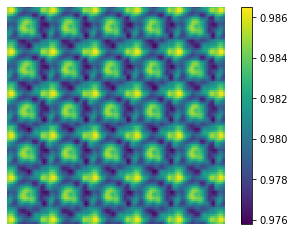

In [55]:
plt.imshow(ssim_map)
plt.axis('off')
plt.colorbar()

In [17]:
# calculate PSNR for each real space position, result in Decibel
psnr_map = np.zeros((truth_data.shape[0],truth_data.shape[1]))
for irow in range(truth_data.shape[0]):
    for icol in range(truth_data.shape[1]):
        truth = truth_data[irow,icol,:].reshape(128,128)
        denoise = denoised_data[irow,icol,:].reshape(128,128)
        psnr_map[irow,icol] = psnr(truth,denoise)

45.67195725037796


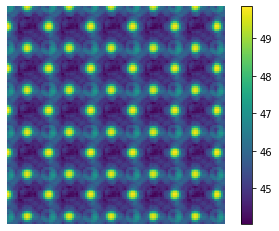

In [18]:
plt.imshow(psnr_map)
plt.colorbar()
plt.axis('off')
print(np.mean(psnr_map))

## Calcualte average PSNR for different noise levels

In [14]:
# load data from different frame rate and calculate the PSNR from denoised data
# Plot input vs output psnr
FPS_list = [1000,2000,4000,6000,8000,20000,40000]
PSNR_list = np.zeros((2,len(FPS_list)))
path = '/srv/home/chenyu/TensorDenoise/Simulatons/STO_simulation/'
for i in range(len(FPS_list)):
    FPS = FPS_list[i]
    truth_file = path + 'Simulation_truth_STO_slice_5_'+str(FPS)+'FPS_fullsize.npy'
    noisy_file = path + 'Simulation_noisy_STO_slice_5_'+str(FPS)+'FPS_fullsize.mat'
    denoise_file = path + 'Simulation_tensor_STO_slice_5_'+str(FPS)+'FPS_fullsize.mat'
    truth_file = np.load(truth_file)
    noisy_file = sio.loadmat(noisy_file)
    noisy_file = noisy_file['datacube']
    denoise_file = sio.loadmat(denoise_file)
    denoise_file = denoise_file['est_HOOI']

    
    PSNR_list[0,i] = averagePSNR(denoise_file,truth_file,0)
    PSNR_list[1,i] = averagePSNR(noisy_file,truth_file,0)
    print(FPS)
    print(averagePSNR(denoise_file,truth_file,0))
    print(averagePSNR(noisy_file,truth_file,0))

1000
45.67195725037796
19.907985114060708
2000
42.951670939936406
16.898697846426
4000
40.03304142559473
13.887413440051443
6000
38.32760788988307
12.12766026404656
8000
37.09538835003427
10.87845355727477
20000
32.980855488298985
6.900473692836278
40000
30.042583207786986
3.8887072938929714


## Make the final plot for manuscript

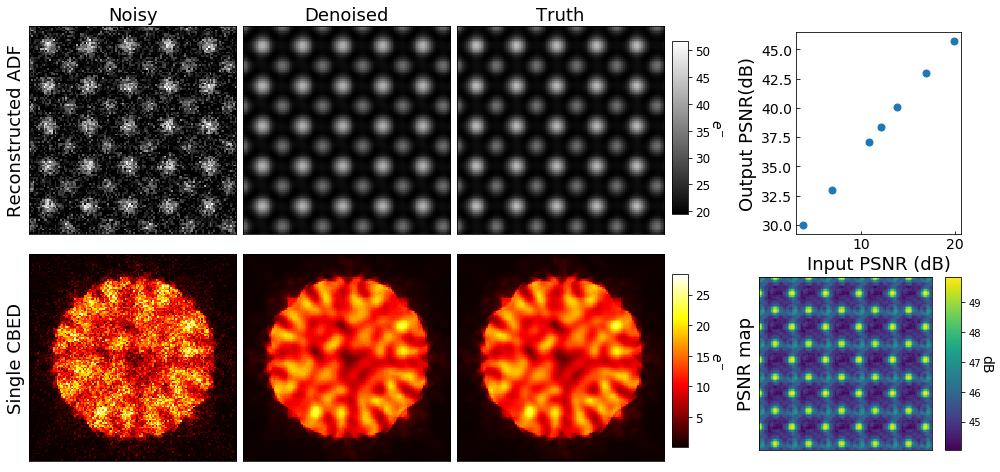

In [19]:
# overall plot
fig = plt.figure(figsize=(23,8))
clim_low = np.amin(ADF_truth)
clim_high = np.amax(ADF_truth)

ax = fig.add_subplot(261)
plt.imshow(ADF_noisy,clim=[clim_low,clim_high*1.2],cmap='gray')
plt.xticks([])
plt.yticks([])
# ax.text(5,104,'a',fontsize=30, color='white', fontweight='bold')
plt.title('Noisy',fontsize=18)
plt.ylabel('Reconstructed ADF', fontsize=18)

ax = fig.add_subplot(262)
plt.imshow(ADF_denoised,clim=[clim_low,clim_high*1.2],cmap='gray')
plt.xticks([])
plt.yticks([])
# ax.text(5,104,'c',fontsize=30, color='white', fontweight='bold')
plt.title('Denoised',fontsize=18)

ax = fig.add_subplot(263)
im = plt.imshow(ADF_truth,clim=[clim_low,clim_high*1.2],cmap='gray')
plt.xticks([])
plt.yticks([])
# ax.text(5,104,'e',fontsize=30, color='white', fontweight='bold')
plt.title('Truth',fontsize=18)

cax = fig.add_axes([0.515,0.555,0.01,0.3])
cbar = plt.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('$e^{-}$',rotation=270,labelpad = 12, fontsize=14)

# plot CBED patterns
rx = 50
ry = 50
clim_low = np.amin(truth_data[rx,ry,:])
clim_high = np.amax(truth_data[rx,ry,:])

ax = fig.add_subplot(267)
plt.imshow(raw_data[rx,ry,:].reshape(128,128),clim=[clim_low,clim_high*1.2],cmap='hot')
plt.xticks([])
plt.yticks([])
# ax.text(5,120,'b',fontsize=30, color='white', fontweight='bold')
plt.ylabel('Single CBED', fontsize=18)

ax = fig.add_subplot(268)
plt.imshow(denoised_data[rx,ry,:].reshape(128,128),clim=[clim_low,clim_high*1.2],cmap='hot')
plt.xticks([])
plt.yticks([])
# ax.text(5,120,'d',fontsize=30, color='white', fontweight='bold')

ax = fig.add_subplot(269)
im = plt.imshow(truth_data[rx,ry,:].reshape(128,128),clim=[clim_low,clim_high*1.2],cmap='hot')
plt.xticks([])
plt.yticks([])
# ax.text(5,120,'f',fontsize=30, color='white', fontweight='bold')
divider = make_axes_locatable(ax)

cax = fig.add_axes([0.515,0.15,0.01,0.3])
cbar = plt.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('$e^{-}$',rotation=270,fontsize=14,labelpad=12)

ax = fig.add_axes([0.59,0.52,0.1,0.35])
ax.plot(PSNR_list[1,:], PSNR_list[0,:], '.',markersize=14)
plt.xlabel('Input PSNR (dB)',fontsize=18)
plt.ylabel('Output PSNR(dB)',fontsize=18)
# plt.text(18,31,'g',fontsize=30, fontweight='bold')
ax.tick_params(direction='in',labelsize = 14)

ax4 = fig.add_axes([0.47,0.145,0.3,0.3])
im = ax4.imshow(psnr_map)
ax4.set_ylabel('PSNR map',fontsize=18)
ax4.set_xticks([])
ax4.set_yticks([])

cax = fig.add_axes([0.68,0.145,0.01,0.3])
cbar = plt.colorbar(im,cax = cax)
cbar.set_label('dB',rotation=270,fontsize=14, labelpad = 12)
# ax4.text(5,104,'h',fontsize=20,color='white', fontweight='bold')

# Save final figure in tif format
fig.subplots_adjust(wspace = 0.0, hspace = 0.1)
fig.savefig('/srv/home/chenyu/TensorDenoise/Simulatons/STO_simulation/STO_sim_results.tif')

## Check scree plots

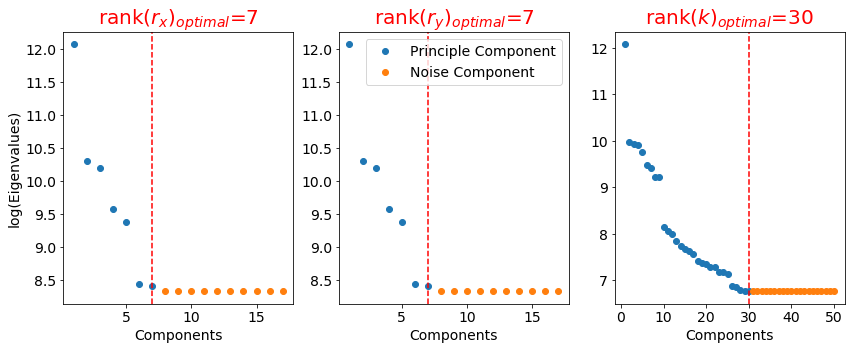

In [2]:
# Analysis eigenvalues
# load the eigenvalues calculated from Matlab
temp = sio.loadmat('/srv/home/chenyu/TensorDenoise/Simulatons/STO_simulation/Simulation_noisy_STO_slice_5_1000FPS_fullsize_eigenvalue.mat')

fig = plt.figure(figsize=(14,5))

ax = fig.add_subplot(131)
e1 = temp['e1']
e1 = e1[::-1]
plt.plot(np.linspace(1,7,7),np.log(e1[0:7]),'o',linewidth='2')
plt.plot(np.linspace(8,17,10),np.log(e1[7:17]),'o',linewidth='2')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.axvline(x=7,color='r',ls='--')
plt.ylabel('log(Eigenvalues)',fontsize=14)
plt.xlabel('Components',fontsize=14)
# ax.text(2,8.5,'a',fontsize=20, color='black', fontweight='bold')
plt.title('rank($\it{r_x})_{optimal}$=7',color='red',fontsize=20)

ax = fig.add_subplot(132)
e2 = temp['e2']
e2 = e2[::-1]
plt.plot(np.linspace(1,7,7),np.log(e1[0:7]),'o',linewidth='2',label = 'Principle Component')
plt.plot(np.linspace(8,17,10),np.log(e1[7:17]),'o',linewidth='2', label = 'Noise Component')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.axvline(x=7,color='r',ls='--')
plt.xlabel('Components',fontsize=14)
# ax.text(2,8.5,'b',fontsize=20, color='black', fontweight='bold')
plt.title('rank($\it{r_y})_{optimal}$=7',color='red',fontsize=20)


ax = fig.add_subplot(133)
e3 = temp['e3']
e3 = e3[::-1]
plt.plot(np.linspace(1,30,30),np.log(e3[0:30]),'o',linewidth='2',label = 'Principle Component')
plt.plot(np.linspace(31,50,20),np.log(e3[30:50]),'o',linewidth='2', label = 'Noise Component')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.axvline(x=30,color='r',ls='--')
plt.xlabel('Components',fontsize=14)
# ax.text(5,7,'c',fontsize=20, color='black', fontweight='bold')
plt.title('rank($\it{k})_{optimal}$=30',color='red',fontsize=20)

fig.savefig('/srv/home/chenyu/TensorDenoise/Simulatons/STO_simulation/STO_sim_screePlots.tif')

In [16]:
np.linspace(1,18,18)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18.])

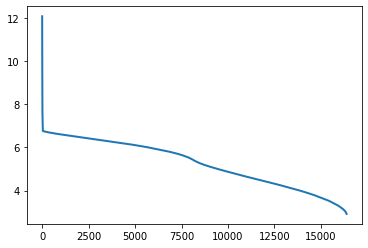

In [7]:
# Check the whole scree plot along the third dimension
e3 = temp['e3']
e3 = e3[::-1]
plt.plot(np.log(e3),linewidth='2')
# plt.axvline(x=29,color='r',ls='--')

## Functions that will be called

In [4]:
def psnr(truth, denoise):
    mse = np.mean( (truth - denoise) ** 2 )
    PIXEL_MAX = np.amax(truth)
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

In [5]:
# transpose_option = 1 for tensor denoised data, where first dimension is for rec space and need to be transposed to match simulation
# transpose_option = 0 for noisy data, third dimension is for rec space and no need to transpose
def averagePSNR(denoised_data,truth_data,transpose_option):
    for irow in range(truth_data.shape[0]):
        for icol in range(truth_data.shape[1]):
            truth = truth_data[irow,icol,:].reshape(128,128)
            if transpose_option == 1:
                denoise = np.transpose(denoised_data[:,irow,icol].reshape(128,128))
            else:
                denoise = denoised_data[irow,icol,:].reshape(128,128)
            psnr_map[irow,icol] = psnr(truth,denoise)
    return np.mean(psnr_map)

In [6]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = [int(w/2), int(h/2)]
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask